<img src='imgs/fb_nvidia_elastic.jpg' width='500'>

# AI Indexing

# <u>Object & HTTP </u> Images
# <u>File / NFS</u> Index
# <u>PSO </u> NVIDIA / Elastic Containers

http server - images  

!cd tbond_imgs ; python3 -m http.server 9000

http://ds:9000/

# Sample Bond

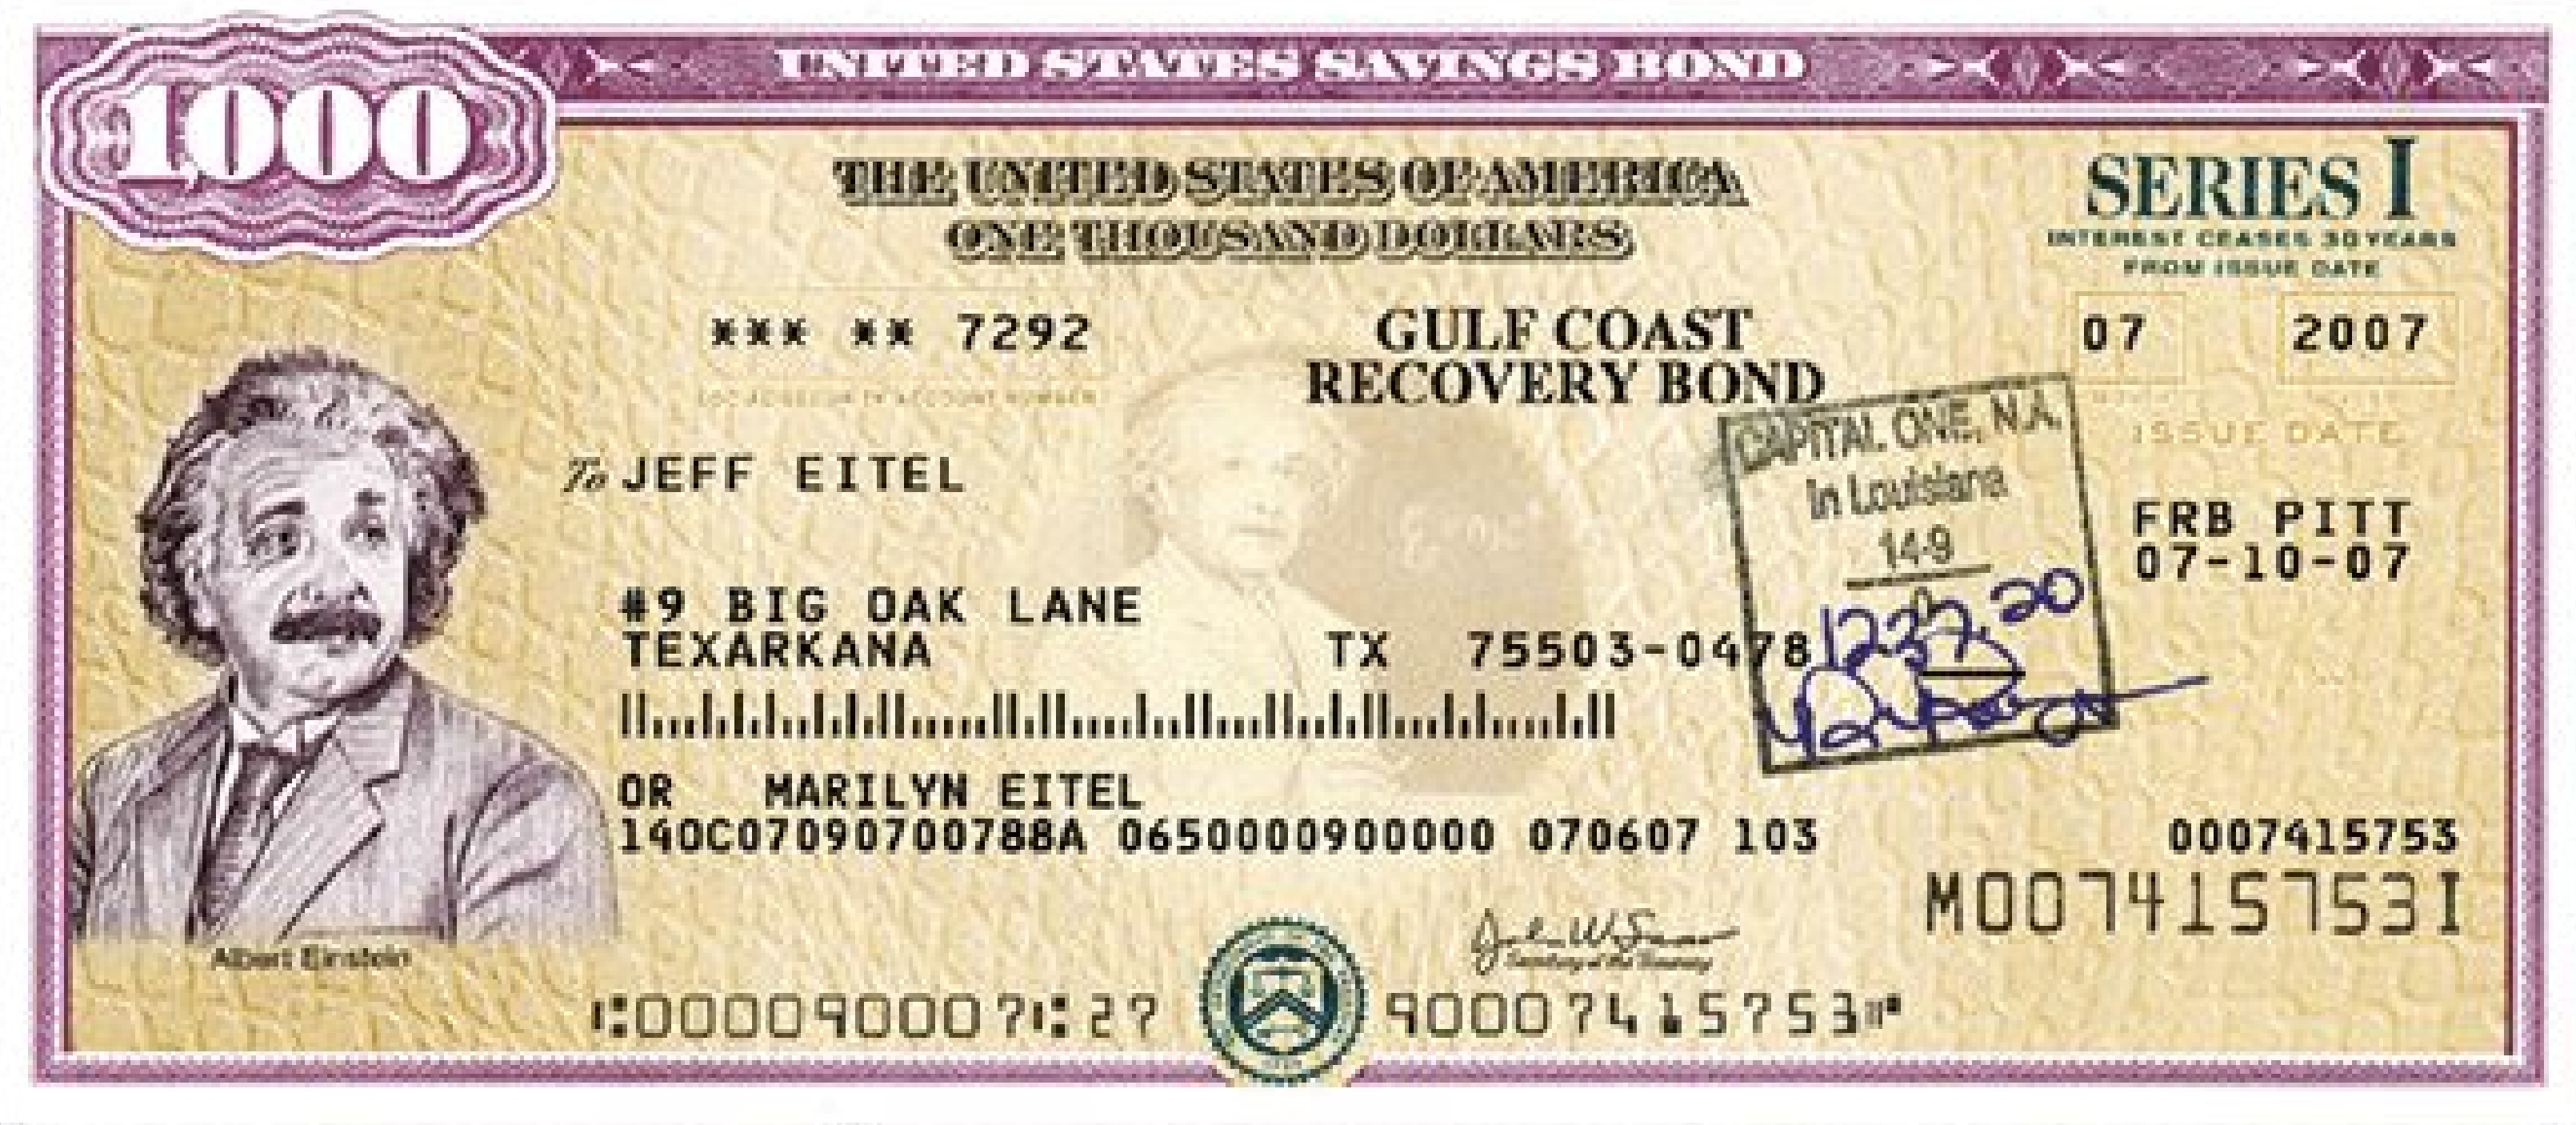

In [56]:
from PIL import Image, ImageDraw
img_dir = 'tbond_imgs/'
img_name = '1000_jeff_eitel_lrg.png'
img = img_dir + img_name
Image.open(img)

# Deep Learning - Bond Value

### NVIDIA DIGITS

__docker__  
    run --gpus all -it --rm  
    -p 5000:5000  
    -v ${PWD}/bond_imgs:/bond_imgs  
    --name digits  
    __nvcr.io/nvidia/digits:20.03-caffe-py3__

http://ds:5000/models/20200602-210626-a683

In [2]:
value_prediction = !curl -s http://ds:5000/models/images/classification/classify_one/json -XPOST \
        -F job_id=20200602-210626-a683 \
        -F image_file=@{img}

value_prediction

['{"predictions":[["1000",100.0],["100",0.0],["50",0.0],["500",0.0],["5000",0.0]]}']

In [5]:
import json
import numpy as np
max_idx = np.array(json.loads(value_prediction[0])['predictions'])[:,1].argmax()
bond_val = int(np.array(json.loads(value_prediction[0])['predictions'])[max_idx,0])
bond_val_confidence = float(np.array(json.loads(value_prediction[0])['predictions'])[max_idx,1])
bond_val, bond_val_confidence

(1000, 100.0)

# Series - EE?

http://ds:5000/models/20200602-173015-1c9c

In [6]:
series_prediction = !curl -s http://ds:5000/models/images/classification/classify_one/json -XPOST -F job_id=20200602-173015-1c9c -F image_file=@{img}
series_prediction

['{"predictions":[["not EE",100.0],["EE",0.0]]}']

In [7]:
max_idx = np.array(json.loads(series_prediction[0])['predictions'])[:,1].argmax()
isEE = 'EE' == np.array(json.loads(series_prediction[0])['predictions'])[max_idx,0]
isEE_confidence = np.array(json.loads(series_prediction[0])['predictions'])[max_idx,1]
isEE, isEE_confidence

(False, '100.0')

<img src='imgs/optuna.png' width=300 align='left'/>

### AutoML / Hyperparameter Tuning

In [8]:
import optuna
study = optuna.load_study(study_name='tbond_ocr', storage='postgresql+psycopg2://admin:ocr@ds:5432/optuna')
optuna.visualization.plot_parallel_coordinate(study, params=['x0_p', 'x1_p','y0_p','y1_p'])

# Deep Learning OCR - Owner Name
<img src='imgs/ocr.png' align='left' width=300/>

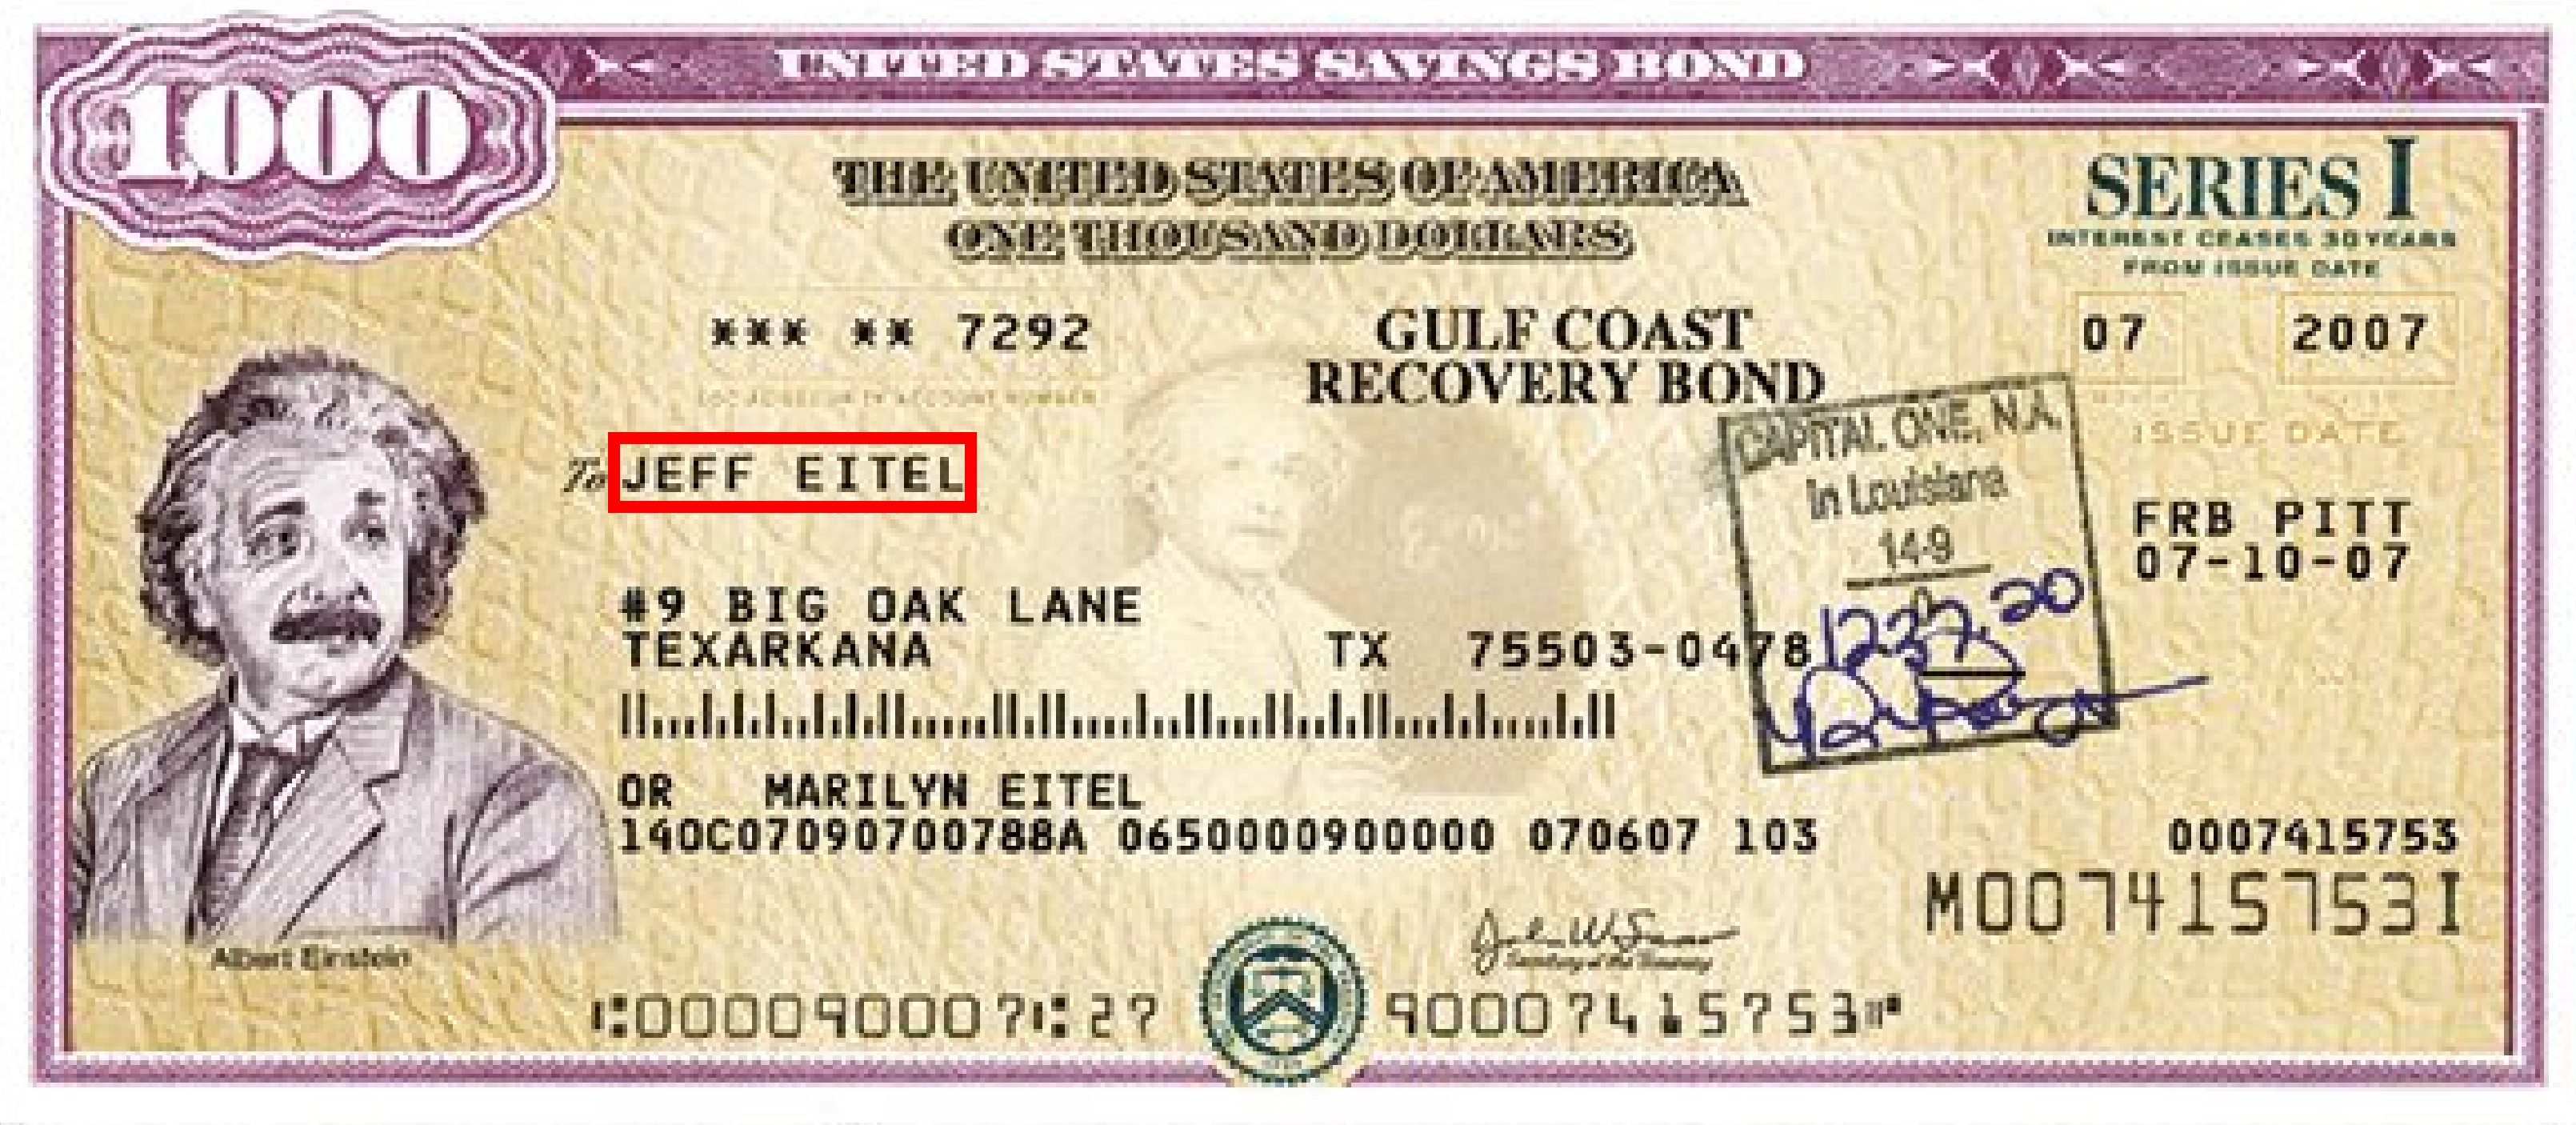

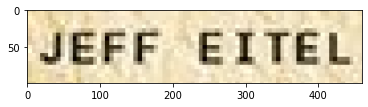

In [61]:
x=760; w=460;
y=540; h=100

import cv2
from matplotlib import pyplot as plt

annotated = Image.open(img)
ImageDraw.Draw(annotated) .rectangle([x,y,x+w,y+h],  outline ="red", width=15) 
display(annotated)
name_img = cv2.imread(img)[y:y+h, x:x+w]
plt.imshow(name_img[:,:,::-1])

Looking for /Users/whill/.keras-ocr/craft_mlt_25k.h5
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Looking for /Users/whill/.keras-ocr/crnn_kurapan.h5


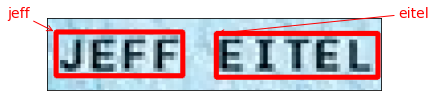

In [62]:
import keras_ocr
name_data = keras_ocr.pipeline.Pipeline(scale=1).recognize([name_img])[0]
keras_ocr.tools.drawAnnotations(image=name_img, predictions=name_data, ax=None)

In [63]:
first_name = name_data[0][0]
last_name = name_data[1][0]
first_name, last_name

('jeff', 'eitel')

<img src='imgs/elastic.png' align='left' width=400/>  

!__docker__ 
            run -d                                            \
            --name elasticsearch                              \
            -h elasticsearch                                  \
            -p 9200:9200                                      \
            -p 9300:9300                                      \
            -e "discovery.type=single-node"                   \
            __elasticsearch__:7.7.0

In [12]:
!wget http://localhost:9200/ -q -O -

{
  "name" : "elasticsearch",
  "cluster_name" : "docker-cluster",
  "cluster_uuid" : "wbH3tqAxRW63e2e_lIgK6w",
  "version" : {
    "number" : "7.7.0",
    "build_flavor" : "default",
    "build_type" : "docker",
    "build_hash" : "81a1e9eda8e6183f5237786246f6dced26a10eaf",
    "build_date" : "2020-05-12T02:01:37.602180Z",
    "build_snapshot" : false,
    "lucene_version" : "8.5.1",
    "minimum_wire_compatibility_version" : "6.8.0",
    "minimum_index_compatibility_version" : "6.0.0-beta1"
  },
  "tagline" : "You Know, for Search"
}


http://localhost:9200

# Index Image 

In [66]:
from elasticsearch import Elasticsearch 
es=Elasticsearch([{'host':'localhost','port':9200}])
tbond={
    "isEE":isEE, 
    "isEE_confidence":isEE_confidence,
    "bond_val":bond_val, 
    "bond_val_confidence":bond_val_confidence,
    "owner_last":last_name,
    "owner_first":first_name,
    "img":img_name,
    "url":"http://ds:9000/series/not_EE/1000_jeff_eitel_lrg.png",
}
es.index(index='tbonds', id='img_name', body=tbond)

{'_index': 'tbonds',
 '_type': '_doc',
 '_id': 'img_name',
 '_version': 3,
 'result': 'updated',
 '_shards': {'total': 2, 'successful': 1, 'failed': 0},
 '_seq_no': 2,
 '_primary_term': 1}

<img src='imgs/kibana.png' width=400 align='left'/>

# Search Images

https://www.elastic.co/guide/en/elasticsearch/reference/current/search-search.html

In [67]:
!wget http://localhost:9200/_search\?pretty\=true\&q\=bond_val:1000 -q -O -

{
  "took" : 697,
  "timed_out" : false,
  "_shards" : {
    "total" : 5,
    "successful" : 5,
    "skipped" : 0,
    "failed" : 0
  },
  "hits" : {
    "total" : {
      "value" : 1,
      "relation" : "eq"
    },
    "max_score" : 1.0,
    "hits" : [
      {
        "_index" : "tbonds",
        "_type" : "_doc",
        "_id" : "img_name",
        "_score" : 1.0,
        "_source" : {
          "isEE" : false,
          "isEE_confidence" : "100.0",
          "bond_val" : 1000,
          "bond_val_confidence" : 100.0,
          "owner_last" : "eitel",
          "owner_first" : "jeff",
          "img" : "1000_jeff_eitel_lrg.png",
          "url" : "http://ds:9000/series/not_EE/1000_jeff_eitel_lrg.png"
        }
      }
    ]
  }
}


!__docker__ 
            run -d                              \
            --name kibana                       \
            -p 5601:5601                        \
            -h kibana                           \
            --link elasticsearch:elasticsearch  \
            __kibana__:7.7.0

http://localhost:5601